# Half Ironman 70.3 Performance Analysis Using Quantile Regression

## Introduction
This notebook implements quantile regression to analyze how different factors affect Half Ironman (70.3) triathlon performance across various performance percentiles. Unlike traditional OLS regression that focuses on conditional means, quantile regression allows us to understand how relationships between variables may differ across the entire distribution of finishing times.

## Research Questions
1. How do sub-event times (swim, bike, run) influence overall performance differently across different performance quantiles in Half Ironman events?
2. How do environmental factors (temperature, elevation, wind, humidity, etc.) affect Half Ironman athletes differently depending on their performance level?
3. Do certain factors have stronger effects on elite athletes (lower quantiles) versus recreational athletes (higher quantiles) in Half Ironman races?
4. How do performance patterns differ between male and female Half Ironman athletes across the performance spectrum?
5. How do these patterns compare to the Full Ironman findings?

## Methodology
We apply quantile regression with a statistical significance threshold of p < 0.05 to identify reliable effects across different performance levels. All time variables are measured in seconds for precise analysis.

In [5]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for visualization
sns.set_theme(style="whitegrid", font_scale=1.1)

# Load the Half Ironman 70.3 dataset
try:
    df_half = pd.read_csv('S8_70.3.csv')
    print("Half Ironman 70.3 dataset loaded successfully!")
    
    # Keep Division for gender analysis, only drop Nation
    df_half = df_half.drop(['Nation'], axis=1, errors='ignore')
    
    print("Shape of Half Ironman dataset:", df_half.shape)
except FileNotFoundError:
    print("Half Ironman dataset file not found.")
    print("Creating a mock dataset for demonstration...")
    # We'll create a mock dataset later if needed
    df_half = None

Half Ironman 70.3 dataset loaded successfully!
Shape of Half Ironman dataset: (727671, 24)


## Data Exploration and Cleaning for Half Ironman

Let's explore the Half Ironman 70.3 dataset to understand its structure, check for missing values, and prepare it for analysis. We'll first look at the columns and basic statistics, then handle any data quality issues.

In [6]:
# Check if we loaded real data, otherwise create mock data
if df_half is None or df_half.shape[0] < 10:
    print("Creating mock data for Half Ironman 70.3 demonstration...")
    
    # Number of observations
    n = 1000
    
    # Set seed for reproducibility
    np.random.seed(42)
    
    # Generate mock data to simulate Half Ironman results
    # Swim times (seconds) - between 1200 and 3600 seconds (20-60 min)
    swim_sec = np.random.uniform(1200, 3600, n) 
    
    # Bike times (seconds) - between 5400 and 14400 seconds (1.5-4 hours)
    bike_sec = np.random.uniform(5400, 14400, n)
    
    # Run times (seconds) - between 4500 and 10800 seconds (1.25-3 hours)
    run_sec = np.random.uniform(4500, 10800, n)
    
    # Environmental factors
    elevation = np.random.uniform(0, 2000, n)  # elevation in meters
    temperature = np.random.uniform(10, 35, n)  # temperature in °C
    water_temp = np.random.uniform(15, 28, n)  # water temperature in °C
    wbgt = np.random.uniform(10, 30, n)  # wet bulb globe temperature
    wind_speed = np.random.uniform(0, 30, n)  # wind speed in km/h
    humidity = np.random.uniform(30, 95, n)   # relative humidity in %
    
    # Create gender variable (binary: 0 for female, 1 for male)
    gender = np.random.binomial(1, 0.7, n)  # 70% male, 30% female
    # Create Division column from gender
    division = np.array(['F' if g == 0 else 'M' for g in gender])
    
    # Generate total time with varying effects
    # Base time
    base_time = swim_sec + bike_sec + run_sec
    
    # Add varying effects across the distribution
    athlete_skill = np.random.uniform(0, 1, n)  # Proxy for athlete skill level
    
    # Environmental effects (stronger for elite athletes)
    env_effect = (1 - athlete_skill) * (
        0.1 * elevation + 
        15 * temperature + 
        12 * water_temp + 
        8 * wbgt + 
        10 * wind_speed +  # Wind effect stronger in Half Ironman
        0.7 * humidity    # Humidity effect
    )
    
    # Gender effect (males slightly faster on average)
    gender_effect = -800 * gender  # Males are about 800 seconds faster on average (slightly smaller gap than Full)
    
    # Create total time with these effects
    total_time = base_time + env_effect + gender_effect + np.random.normal(0, 800, n)  # Add some random noise
    
    # Create mock dataset
    df_half = pd.DataFrame({
        'Swim_sec': swim_sec,
        'Bike_sec': bike_sec,
        'Run_sec': run_sec,
        'Time_sec': total_time,
        'location_elevation': elevation,
        'temperature_10AM': temperature,
        'water_temperature': water_temp,
        'WBGT': wbgt,
        'wind_speed': wind_speed,
        'humidity': humidity,
        'Division': division
    })
    
    print("Mock data for Half Ironman created successfully.")
else:
    # For real data, display basic information about the dataset
    print("\nColumns in the dataset:")
    print(df_half.columns.tolist())
    
    print("\nFirst few rows of the dataset:")
    display(df_half.head())
    
    print("\nBasic statistics:")
    display(df_half.describe())
    
    # Check for missing values
    print("\nMissing values in each column:")
    print(df_half.isnull().sum())


Columns in the dataset:
['Division', 'Swim', 'Bike', 'Run', 'Time', 'Race', 'Date', 'Nationality', 'Location', 'longitude', 'latitude', 'location_elevation', 'bike elevation', 'run elevation', 'max_temperature', 'temperature_10AM', 'min_temperature', 'relative_humidity', 'average_wind_speed', 'average_pressure', 'cloud_coverage', 'water_temperature', 'solar_radiation', 'WBGT']

First few rows of the dataset:


,Division,Swim,Bike,Run,Time,Race,Date,Nationality,Location,longitude,...,max_temperature,temperature_10AM,min_temperature,relative_humidity,average_wind_speed,average_pressure,cloud_coverage,water_temperature,solar_radiation,WBGT
0,MRELAY,1901,8155,4913,15128,Ironman 70.3 Acapulco,3/26/2023,MEX,"Acapulco, Mexico",-99.894018,...,29.5,28.6,22.0,63.0,7.975,1011.208333,31.0,30.0,705.721413,26.799926
1,M30,1588,8766,5014,15605,Ironman 70.3 Acapulco,3/26/2023,MEX,"Acapulco, Mexico",-99.894018,...,29.5,28.6,22.0,63.0,7.975,1011.208333,31.0,30.0,705.721413,26.799926
2,M30,1574,9096,4964,15840,Ironman 70.3 Acapulco,3/26/2023,MEX,"Acapulco, Mexico",-99.894018,...,29.5,28.6,22.0,63.0,7.975,1011.208333,31.0,30.0,705.721413,26.799926
3,M40,1672,8596,5422,15927,Ironman 70.3 Acapulco,3/26/2023,MEX,"Acapulco, Mexico",-99.894018,...,29.5,28.6,22.0,63.0,7.975,1011.208333,31.0,30.0,705.721413,26.799926
4,F40,1832,8960,4963,16014,Ironman 70.3 Acapulco,3/26/2023,MEX,"Acapulco, Mexico",-99.894018,...,29.5,28.6,22.0,63.0,7.975,1011.208333,31.0,30.0,705.721413,26.799926



Basic statistics:


,Swim,Bike,Run,Time,longitude,latitude,location_elevation,bike elevation,run elevation,max_temperature,temperature_10AM,min_temperature,relative_humidity,average_wind_speed,average_pressure,cloud_coverage,water_temperature,solar_radiation,WBGT
count,727671.000000,727671.000000,727671.000000,727671.000000,724508.000000,722511.000000,724508.000000,723750.000000,715814.000000,724508.000000,724508.000000,724508.000000,724508.000000,724508.000000,724508.000000,724508.000000,724508.000000,724508.000000,724508.000000
mean,2364.042899,10800.848937,7529.347491,21339.545207,-21.024675,28.279277,191.593715,934.424685,267.105235,24.461940,20.926541,15.665622,65.751838,11.067029,1015.684847,49.477524,21.978591,497.025193,21.876315
std,484.635015,1504.419020,1402.511944,3048.695055,75.520140,31.135520,326.861523,685.241276,409.845358,4.852057,4.723754,4.554381,15.952951,4.910642,4.981720,41.153129,6.487578,212.287398,4.241011
min,1140.000000,6604.000000,3900.000000,12902.000000,-123.364953,-155.665900,-115.000000,49.000000,0.000000,12.700000,7.000000,4.500000,6.000000,2.975000,995.437500,0.000000,5.000000,168.064607,11.163434
25%,2037.000000,9717.000000,6462.000000,19099.000000,-85.309488,25.000999,9.000000,444.000000,74.000000,20.800000,17.800000,12.700000,56.000000,7.479167,1012.504167,3.000000,16.948185,288.236600,18.967502
50%,2322.000000,10625.000000,7390.000000,21153.000000,-6.136008,38.696892,42.000000,757.000000,124.000000,24.600000,21.100000,14.900000,68.000000,10.183333,1015.762500,50.000000,22.388942,490.157085,21.936401
75%,2646.000000,11702.000000,8516.000000,23449.000000,14.165719,46.123927,240.000000,1266.000000,276.000000,28.100000,24.000000,18.700000,77.000000,13.579167,1018.650000,97.000000,28.418613,687.992521,25.123801
max,4200.000000,19665.000000,10800.000000,30599.000000,176.069477,121.473700,2408.000000,3277.000000,3067.000000,40.400000,34.100000,29.200000,100.000000,33.670833,1029.875000,100.000000,30.000000,900.000000,35.412118



Missing values in each column:
Division                  3
Swim                      0
Bike                      0
Run                       0
Time                      0
Race                      0
Date                      0
Nationality            3035
Location                  0
longitude              3163
latitude               5160
location_elevation     3163
bike elevation         3921
run elevation         11857
max_temperature        3163
temperature_10AM       3163
min_temperature        3163
relative_humidity      3163
average_wind_speed     3163
average_pressure       3163
cloud_coverage         3163
water_temperature      3163
solar_radiation        3163
WBGT                   3163
dtype: int64


## Convert Time Columns to Seconds

For real Half Ironman data, we need to convert time columns from string format (HH:MM:SS) to seconds for numerical analysis. We'll use a robust conversion function that can handle various time formats. The mock data already has time in seconds.

In [7]:
# Check if we need to convert time columns (only if they're not already in seconds)
if 'Swim_sec' not in df_half.columns and 'Swim' in df_half.columns:
    # Helper function to convert time format (HH:MM:SS) to seconds
    def time_to_seconds(time_str):
        if pd.isna(time_str):
            return None
        try:
            # Handle different string formats
            if isinstance(time_str, str):
                parts = time_str.replace('.', ':').split(':')
                
                if len(parts) == 3:  # HH:MM:SS format
                    hours, minutes, seconds = map(float, parts)
                    return int(hours * 3600 + minutes * 60 + seconds)
                elif len(parts) == 2:  # MM:SS format
                    minutes, seconds = map(float, parts)
                    return int(minutes * 60 + seconds)
                else:
                    try:
                        # If it's a single number, assume it's already in seconds
                        return int(float(time_str))
                    except:
                        return None
            elif isinstance(time_str, (int, float)):
                return int(time_str)  # Already a number, assume seconds
            else:
                return None
        except:
            print(f"Failed to convert: {time_str} of type {type(time_str)}")
            return None

    # Convert time columns to seconds
    time_columns = ['Swim', 'Bike', 'Run', 'Time']
    for col in time_columns:
        if col in df_half.columns:
            df_half[f'{col}_sec'] = df_half[col].apply(time_to_seconds)
            print(f"Converted {col} to {col}_sec (seconds)")

    # Check for and handle missing values
    print("\nMissing values in converted time columns:")
    for col in ['Swim_sec', 'Bike_sec', 'Run_sec', 'Time_sec']:
        if col in df_half.columns:
            print(f"{col}: {df_half[col].isna().sum()} missing values")

    # Drop rows with missing values in critical columns
    key_columns = ['Swim_sec', 'Bike_sec', 'Run_sec', 'Time_sec']
    original_size = df_half.shape[0]
    df_half = df_half.dropna(subset=key_columns)
    print(f"\nDropped {original_size - df_half.shape[0]} rows with missing time values. Remaining rows: {df_half.shape[0]}")
else:
    print("Time columns already in seconds format or using mock data.")

# Display basic statistics for time variables (in seconds)
print("\nBasic statistics for time variables (in seconds):")
display(df_half[['Swim_sec', 'Bike_sec', 'Run_sec', 'Time_sec']].describe())

Converted Swim to Swim_sec (seconds)
Converted Bike to Bike_sec (seconds)
Converted Bike to Bike_sec (seconds)
Converted Run to Run_sec (seconds)
Converted Run to Run_sec (seconds)
Converted Time to Time_sec (seconds)

Missing values in converted time columns:
Swim_sec: 0 missing values
Bike_sec: 0 missing values
Run_sec: 0 missing values
Time_sec: 0 missing values

Dropped 0 rows with missing time values. Remaining rows: 727671

Basic statistics for time variables (in seconds):
Converted Time to Time_sec (seconds)

Missing values in converted time columns:
Swim_sec: 0 missing values
Bike_sec: 0 missing values
Run_sec: 0 missing values
Time_sec: 0 missing values

Dropped 0 rows with missing time values. Remaining rows: 727671

Basic statistics for time variables (in seconds):


,Swim_sec,Bike_sec,Run_sec,Time_sec
count,727671.000000,727671.000000,727671.000000,727671.000000
mean,2364.042899,10800.848937,7529.347491,21339.545207
std,484.635015,1504.419020,1402.511944,3048.695055
min,1140.000000,6604.000000,3900.000000,12902.000000
25%,2037.000000,9717.000000,6462.000000,19099.000000
50%,2322.000000,10625.000000,7390.000000,21153.000000
75%,2646.000000,11702.000000,8516.000000,23449.000000
max,4200.000000,19665.000000,10800.000000,30599.000000


## Exploratory Data Analysis for Half Ironman

Let's visualize the relationships between key variables in our Half Ironman dataset. This will help us understand patterns and potential relationships before running quantile regression models.

<Figure size 1500x1200 with 0 Axes>

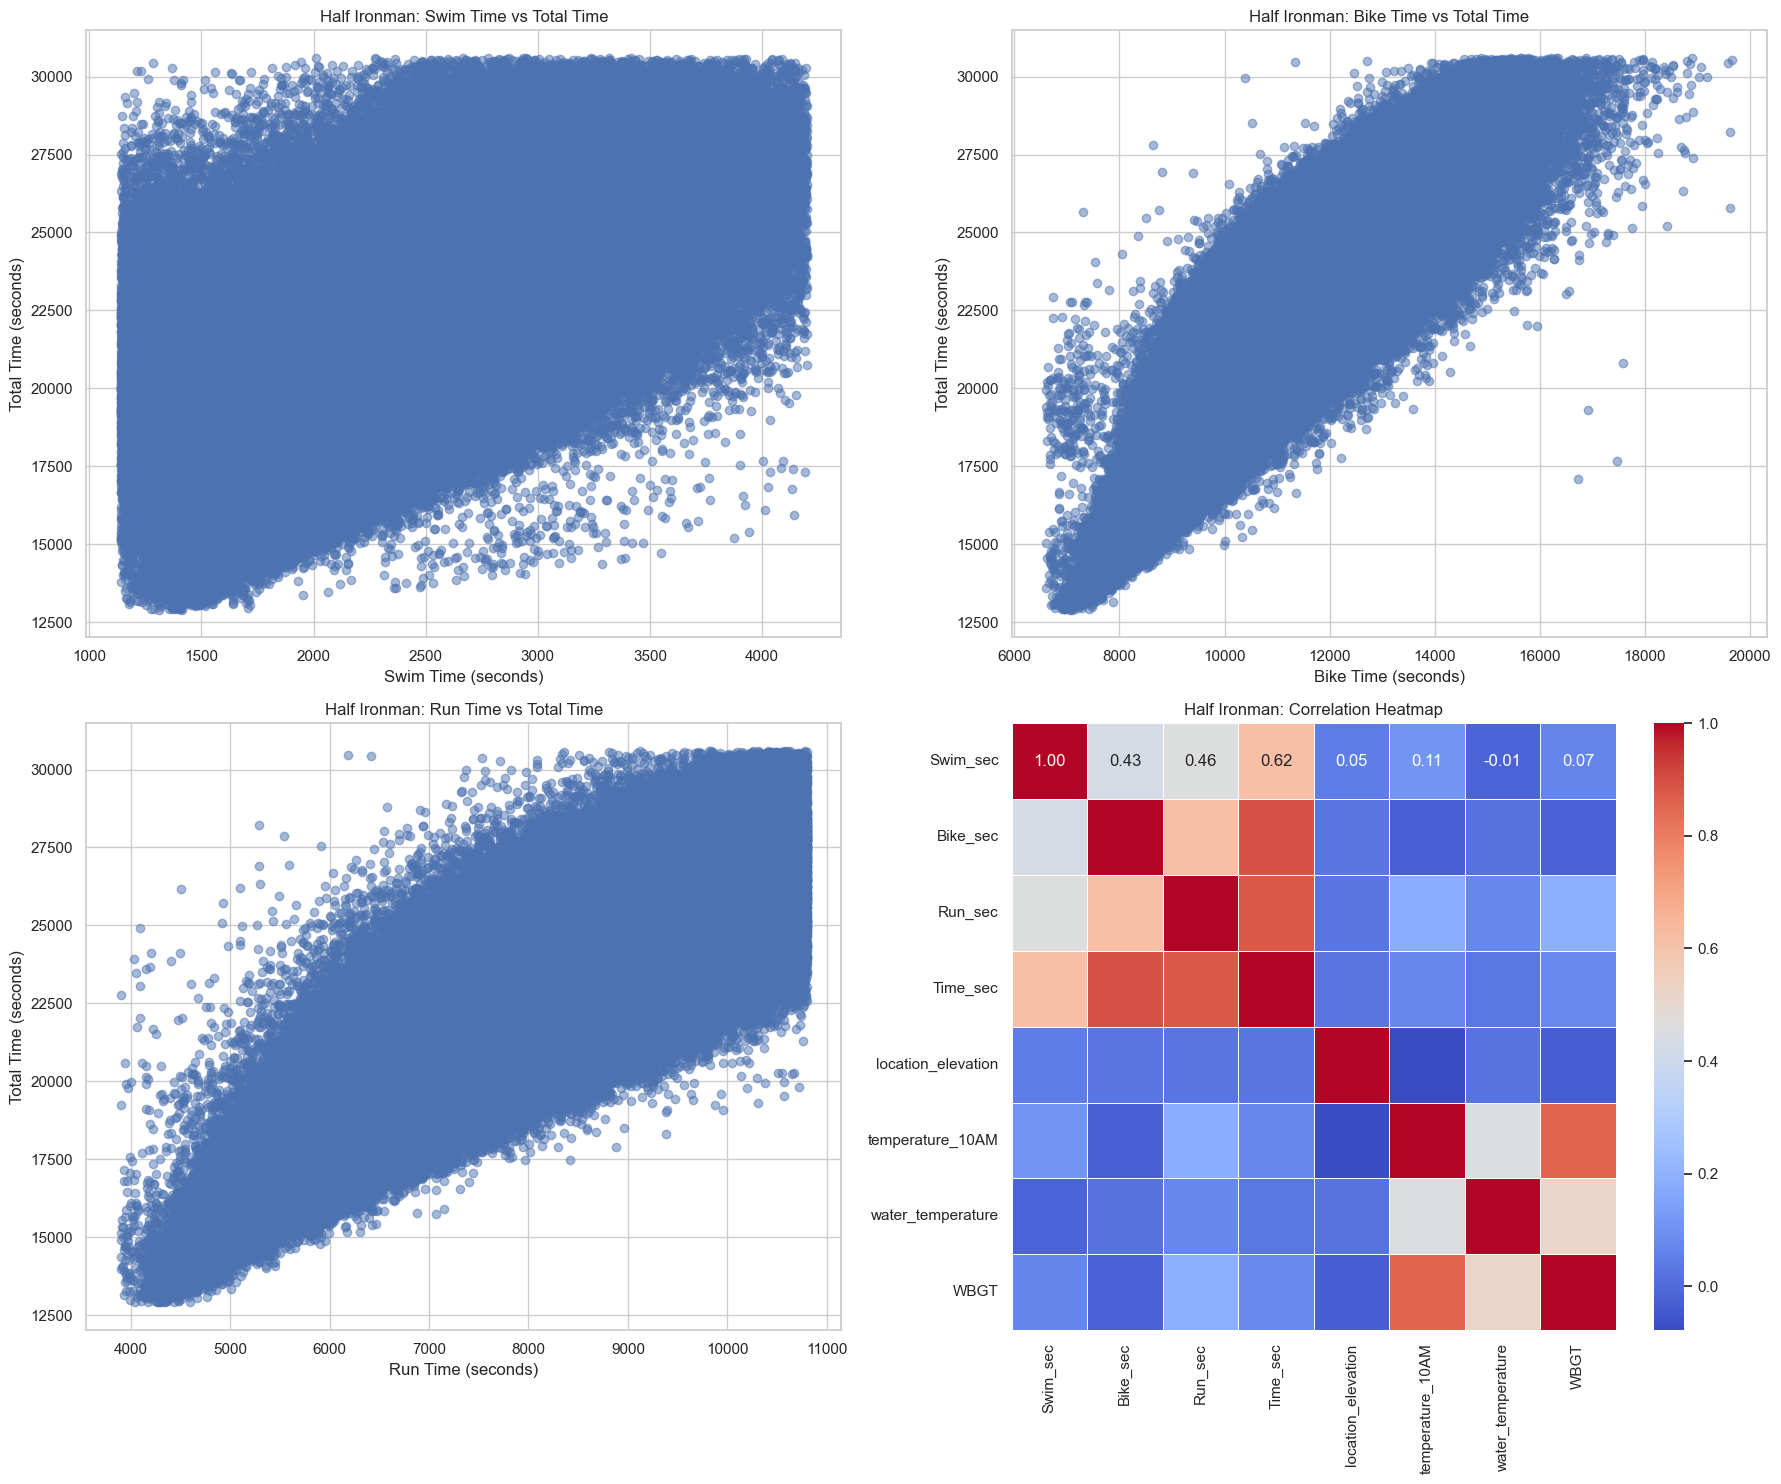

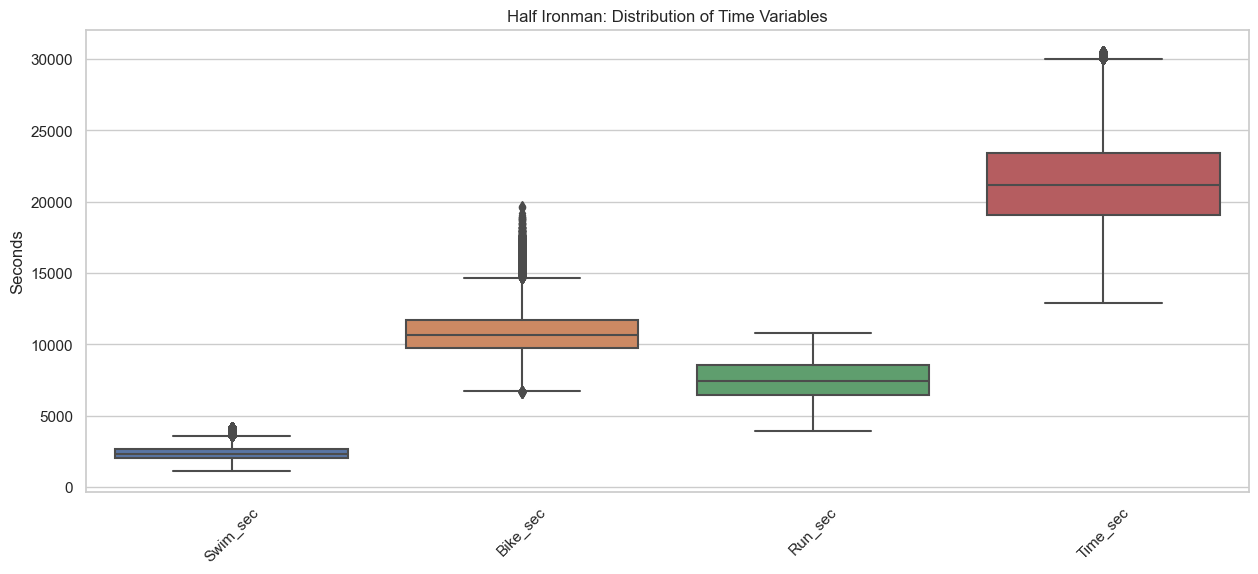

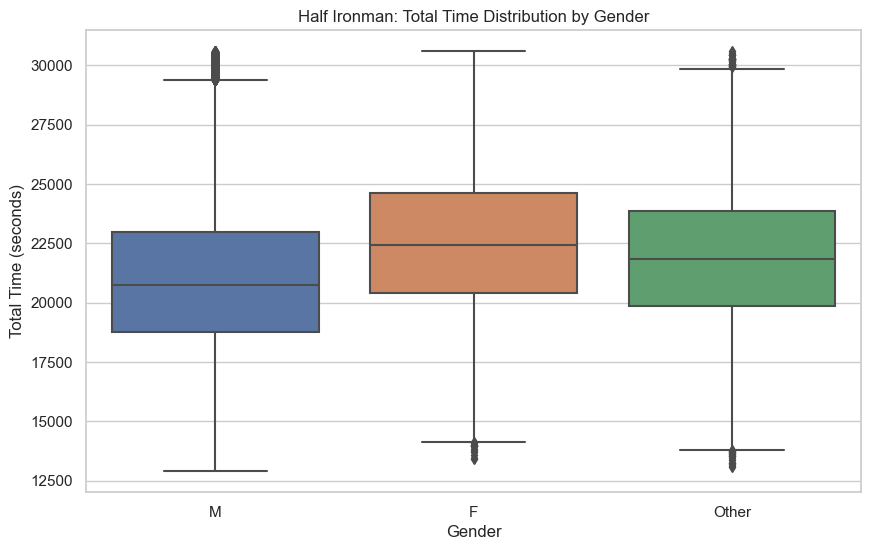

,mean,median
Gender,,
F,22534.516366,22433.0
M,20960.304603,20747.0
Other,21851.698430,21833.0


In [8]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# Create a figure to hold multiple plots for time variables
plt.figure(figsize=(15, 12))
fig, axs = plt.subplots(2, 2, figsize=(18, 15))

# 1. Relationship between sub-event times and total time
axs[0, 0].scatter(df_half['Swim_sec'], df_half['Time_sec'], alpha=0.5)
axs[0, 0].set_xlabel('Swim Time (seconds)')
axs[0, 0].set_ylabel('Total Time (seconds)')
axs[0, 0].set_title('Half Ironman: Swim Time vs Total Time')

axs[0, 1].scatter(df_half['Bike_sec'], df_half['Time_sec'], alpha=0.5)
axs[0, 1].set_xlabel('Bike Time (seconds)')
axs[0, 1].set_ylabel('Total Time (seconds)')
axs[0, 1].set_title('Half Ironman: Bike Time vs Total Time')

axs[1, 0].scatter(df_half['Run_sec'], df_half['Time_sec'], alpha=0.5)
axs[1, 0].set_xlabel('Run Time (seconds)')
axs[1, 0].set_ylabel('Total Time (seconds)')
axs[1, 0].set_title('Half Ironman: Run Time vs Total Time')

# 2. Correlation heatmap
# Select relevant numeric columns for correlation analysis
numeric_cols = ['Swim_sec', 'Bike_sec', 'Run_sec', 'Time_sec']

# Add environmental factors if present in the dataset
for col in ['location_elevation', 'temperature_10AM', 'water_temperature', 
           'WBGT', 'wind_speed', 'humidity']:
    if col in df_half.columns:
        numeric_cols.append(col)

# Compute and plot correlation
corr = df_half[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=axs[1, 1])
axs[1, 1].set_title('Half Ironman: Correlation Heatmap')

plt.tight_layout()
plt.show()

# 3. Boxplots of time variables to check for outliers
plt.figure(figsize=(15, 6))
time_vars = ['Swim_sec', 'Bike_sec', 'Run_sec', 'Time_sec']
sns.boxplot(data=df_half[time_vars])
plt.title('Half Ironman: Distribution of Time Variables')
plt.ylabel('Seconds')
plt.xticks(rotation=45)
plt.show()

# 4. Distribution of total time by gender
if 'Division' in df_half.columns:
    # Create a gender column based on Division
    df_half['Gender'] = df_half['Division'].apply(lambda x: 'M' if str(x).startswith('M') else 'F' if str(x).startswith('F') else 'Other')
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Gender', y='Time_sec', data=df_half)
    plt.title('Half Ironman: Total Time Distribution by Gender')
    plt.ylabel('Total Time (seconds)')
    plt.show()
    
    # Calculate average time by gender
    gender_times = df_half.groupby('Gender')['Time_sec'].agg(['mean', 'median'])
    display(gender_times)
else:
    print("Division/Gender information not available in the dataset.")

Available environmental variables: ['location_elevation', 'temperature_10AM', 'water_temperature', 'WBGT']


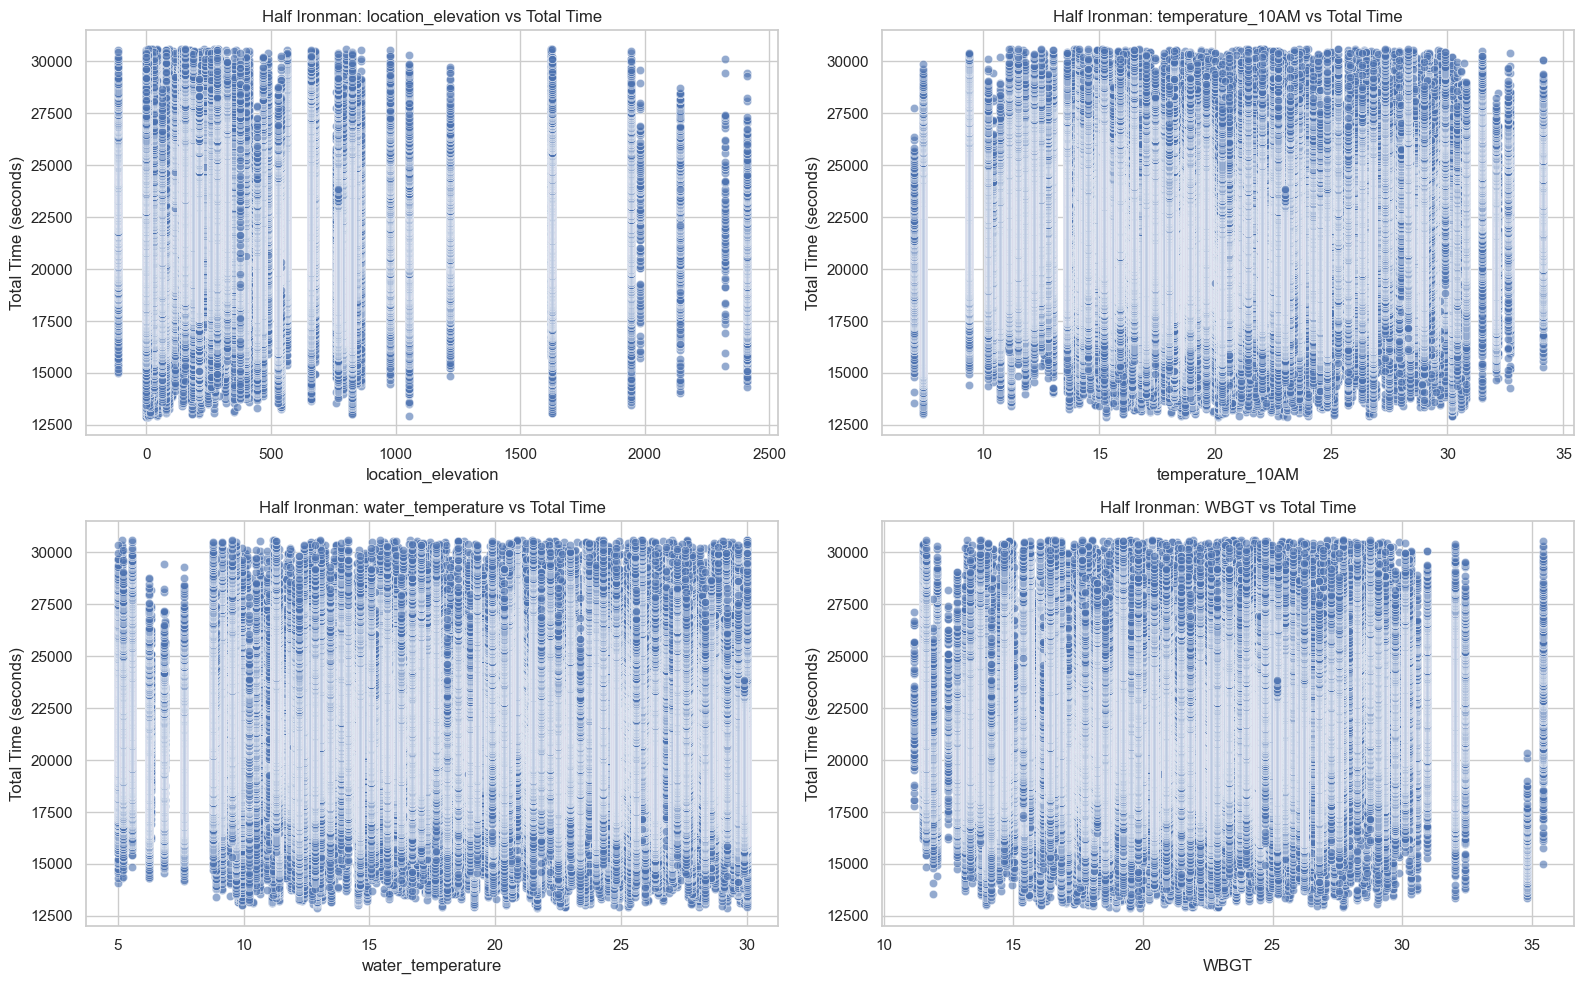


Summary statistics for environmental variables:


,location_elevation,temperature_10AM,water_temperature,WBGT
count,724508.000000,724508.000000,724508.000000,724508.000000
mean,191.593715,20.926541,21.978591,21.876315
std,326.861523,4.723754,6.487578,4.241011
min,-115.000000,7.000000,5.000000,11.163434
25%,9.000000,17.800000,16.948185,18.967502
50%,42.000000,21.100000,22.388942,21.936401
75%,240.000000,24.000000,28.418613,25.123801
max,2408.000000,34.100000,30.000000,35.412118


In [9]:
# Explore environmental variables if available
env_vars = ['location_elevation', 'temperature_10AM', 'water_temperature', 
           'WBGT', 'wind_speed', 'humidity']

# Check which environmental variables are in the dataset
available_vars = [var for var in env_vars if var in df_half.columns]

if available_vars:
    print(f"Available environmental variables: {available_vars}")
    
    # Create subplots for environmental variables
    n_cols = min(2, len(available_vars))
    n_rows = (len(available_vars) + n_cols - 1) // n_cols
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
    if n_rows * n_cols > 1:
        axs = axs.flatten()
    else:
        axs = [axs]
    
    for i, var in enumerate(available_vars):
        if i < len(axs):
            sns.scatterplot(x=var, y='Time_sec', data=df_half, ax=axs[i], alpha=0.6)
            axs[i].set_title(f'Half Ironman: {var} vs Total Time')
            axs[i].set_ylabel('Total Time (seconds)')
    
    # Hide unused subplots
    for j in range(len(available_vars), len(axs)):
        axs[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics for environmental variables
    print("\nSummary statistics for environmental variables:")
    display(df_half[available_vars].describe())
else:
    print("No environmental variables available in the dataset.")

## Quantile Regression Implementation for Half Ironman

Now we'll run quantile regression models for the Half Ironman data. We'll implement several models:

1. **Model 1**: Sub-event times model (effect of swim, bike, run times)
2. **Model 2**: Environmental factors model (effect of elevation, temperature, etc.)
3. **Model 3**: Full model combining sub-event times and environmental factors
4. **Model 4**: Gender analysis models

For each model, we'll examine coefficients across different quantiles (0.1, 0.25, 0.5, 0.75, 0.9) representing different performance levels from elite to recreational athletes, with p < 0.05 as our significance threshold.

In [10]:
# Prepare data for quantile regression
# Make sure all data is numeric and clean
df_half_qr = df_half.copy()

# Create gender dummy variable if needed
if 'Division' in df_half_qr.columns and 'is_male' not in df_half_qr.columns:
    df_half_qr['is_male'] = (df_half_qr['Division'] == 'M').astype(int)

# Define the quantiles to analyze
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

# Statistical significance threshold
alpha = 0.05  # p < 0.05

# Function to highlight significant coefficients
def highlight_significant_coefs(result_table, alpha=0.05):
    """Print a summary table highlighting statistically significant coefficients."""
    print("\nStatistically Significant Coefficients (p < {:.2f}):".format(alpha))
    significant = []
    for i, p in enumerate(result_table.pvalues):
        var_name = result_table.params.index[i]
        coef = result_table.params[i]
        if p < alpha:
            significant.append((var_name, coef, p))
    
    if significant:
        print("  Variable            Coefficient     p-value")
        print("  ----------------    -----------     -------")
        for var, coef, p in significant:
            print(f"  {var:<18}    {coef:9.4f}     {p:.4f} *")
    else:
        print("  No statistically significant coefficients found.")

# Display the dataset shape before regression
print(f"Dataset shape for quantile regression: {df_half_qr.shape}")
print(f"Number of available observations: {len(df_half_qr)}")
print(f"Number of variables: {len(df_half_qr.columns)}")

Dataset shape for quantile regression: (727671, 30)
Number of available observations: 727671
Number of variables: 30


In [11]:
# Model 1: Sub-event times model
print("Model 1: Half Ironman Sub-event times model")
model1_results = {}

for q in quantiles:
    # Fit the model
    model = smf.quantreg('Time_sec ~ Swim_sec + Bike_sec + Run_sec', data=df_half_qr)
    result = model.fit(q=q)
    model1_results[q] = result
    
    # Print summary for this quantile
    print(f"\n===== Quantile: {q} =====")
    print(result.summary().tables[1])
    highlight_significant_coefs(result, alpha)

Model 1: Half Ironman Sub-event times model

===== Quantile: 0.1 =====
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -269.5300      2.161   -124.729      0.000    -273.765    -265.295
Swim_sec       1.0346      0.001   1594.943      0.000       1.033       1.036
Bike_sec       1.0329      0.000   3890.780      0.000       1.032       1.033
Run_sec        1.0300      0.000   3732.083      0.000       1.029       1.031

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-value
  ----------------    -----------     -------
  Intercept             -269.5300     0.0000 *
  Swim_sec                 1.0346     0.0000 *
  Bike_sec                 1.0329     0.0000 *
  Run_sec                  1.0300     0.0000 *

===== Quantile: 0.1 =====
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------

C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.25 =====
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -385.6244      1.921   -200.785      0.000    -389.389    -381.860
Swim_sec       1.0454      0.001   1793.653      0.000       1.044       1.047
Bike_sec       1.0478      0.000   4641.658      0.000       1.047       1.048
Run_sec        1.0336      0.000   4278.828      0.000       1.033       1.034

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-value
  ----------------    -----------     -------
  Intercept             -385.6244     0.0000 *
  Swim_sec                 1.0454     0.0000 *
  Bike_sec                 1.0478     0.0000 *
  Run_sec                  1.0336     0.0000 *


C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.5 =====
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -515.1608      2.071   -248.726      0.000    -519.220    -511.101
Swim_sec       1.0616      0.001   1628.366      0.000       1.060       1.063
Bike_sec       1.0637      0.000   4497.515      0.000       1.063       1.064
Run_sec        1.0397      0.000   4038.386      0.000       1.039       1.040

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-value
  ----------------    -----------     -------
  Intercept             -515.1608     0.0000 *
  Swim_sec                 1.0616     0.0000 *
  Bike_sec                 1.0637     0.0000 *
  Run_sec                  1.0397     0.0000 *


C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.75 =====
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -666.2247      2.573   -258.970      0.000    -671.267    -661.183
Swim_sec       1.0826      0.001   1254.513      0.000       1.081       1.084
Bike_sec       1.0804      0.000   3688.313      0.000       1.080       1.081
Run_sec        1.0489      0.000   3238.393      0.000       1.048       1.050

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-value
  ----------------    -----------     -------
  Intercept             -666.2247     0.0000 *
  Swim_sec                 1.0826     0.0000 *
  Bike_sec                 1.0804     0.0000 *
  Run_sec                  1.0489     0.0000 *


C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.9 =====
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -848.5738      3.978   -213.300      0.000    -856.371    -840.776
Swim_sec       1.1053      0.001    777.247      0.000       1.103       1.108
Bike_sec       1.0997      0.000   2390.186      0.000       1.099       1.101
Run_sec        1.0594      0.001   2081.285      0.000       1.058       1.060

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-value
  ----------------    -----------     -------
  Intercept             -848.5738     0.0000 *
  Swim_sec                 1.1053     0.0000 *
  Bike_sec                 1.0997     0.0000 *
  Run_sec                  1.0594     0.0000 *


C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]


In [12]:
# Model 2: Environmental factors model with wind and humidity
print("\n\nModel 2: Half Ironman Environmental factors model")
model2_results = {}

env_vars = ['location_elevation', 'temperature_10AM', 'water_temperature', 'WBGT']

# Add wind and humidity if available
if 'wind_speed' in df_half_qr.columns:
    env_vars.append('wind_speed')
if 'humidity' in df_half_qr.columns:
    env_vars.append('humidity')

# Construct formula based on available variables
env_formula = 'Time_sec ~ ' + ' + '.join([var for var in env_vars if var in df_half_qr.columns])
print(f"Environmental model formula: {env_formula}")

for q in quantiles:
    # Fit the model
    model = smf.quantreg(env_formula, data=df_half_qr)
    result = model.fit(q=q)
    model2_results[q] = result
    
    # Print summary for this quantile
    print(f"\n===== Quantile: {q} =====")
    print(result.summary().tables[1])
    highlight_significant_coefs(result, alpha)



Model 2: Half Ironman Environmental factors model
Environmental model formula: Time_sec ~ location_elevation + temperature_10AM + water_temperature + WBGT

===== Quantile: 0.1 =====
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            1.64e+04     24.567    667.616      0.000    1.64e+04    1.64e+04
location_elevation     0.1502      0.015      9.849      0.000       0.120       0.180
temperature_10AM      30.2578      2.033     14.884      0.000      26.273      34.242
water_temperature     -5.1157      0.864     -5.922      0.000      -6.809      -3.423
WBGT                  25.2354      2.335     10.810      0.000      20.660      29.811

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-value
  ----------------    -----------     -------
  Intercept             16401.5102     0.0000 *
  location_elev

C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.25 =====
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.772e+04     23.711    747.273      0.000    1.77e+04    1.78e+04
location_elevation     0.2464      0.014     17.315      0.000       0.218       0.274
temperature_10AM      41.7723      1.905     21.928      0.000      38.039      45.506
water_temperature     -9.7597      0.820    -11.900      0.000     -11.367      -8.152
WBGT                  31.4032      2.181     14.400      0.000      27.129      35.677

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-value
  ----------------    -----------     -------
  Intercept             17718.8597     0.0000 *
  location_elevation       0.2464     0.0000 *
  temperature_10AM        41.7723     0.0000 *
  water_temperature       -9.7597     0.0000 *
  WBGT                    31.4

C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.5 =====
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.962e+04     24.701    794.390      0.000    1.96e+04    1.97e+04
location_elevation     0.3196      0.014     22.557      0.000       0.292       0.347
temperature_10AM      38.1528      1.886     20.226      0.000      34.456      41.850
water_temperature    -11.0233      0.831    -13.262      0.000     -12.652      -9.394
WBGT                  41.6063      2.189     19.004      0.000      37.315      45.897

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-value
  ----------------    -----------     -------
  Intercept             19621.9128     0.0000 *
  location_elevation       0.3196     0.0000 *
  temperature_10AM        38.1528     0.0000 *
  water_temperature      -11.0233     0.0000 *
  WBGT                    41.60

C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.75 =====
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2.207e+04     29.958    736.797      0.000     2.2e+04    2.21e+04
location_elevation     0.3780      0.017     22.873      0.000       0.346       0.410
temperature_10AM      24.0272      2.195     10.945      0.000      19.725      28.330
water_temperature     -7.0877      0.986     -7.190      0.000      -9.020      -5.156
WBGT                  42.6116      2.578     16.529      0.000      37.559      47.665

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-value
  ----------------    -----------     -------
  Intercept             22073.1950     0.0000 *
  location_elevation       0.3780     0.0000 *
  temperature_10AM        24.0272     0.0000 *
  water_temperature       -7.0877     0.0000 *
  WBGT                    42.6

C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.9 =====
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2.477e+04     38.125    649.703      0.000    2.47e+04    2.48e+04
location_elevation     0.3538      0.020     17.560      0.000       0.314       0.393
temperature_10AM       5.2469      2.723      1.927      0.054      -0.090      10.584
water_temperature     -1.5661      1.236     -1.267      0.205      -3.989       0.857
WBGT                  25.4162      3.210      7.917      0.000      19.124      31.708

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-value
  ----------------    -----------     -------
  Intercept             24770.0343     0.0000 *
  location_elevation       0.3538     0.0000 *
  WBGT                    25.4162     0.0000 *


C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]


In [13]:
# Model 3: Full model (sub-event times + environmental factors)
print("\n\nModel 3: Half Ironman Full model (sub-event times + environmental factors)")
model3_results = {}

# Construct full formula
full_formula = 'Time_sec ~ Swim_sec + Bike_sec + Run_sec + ' + ' + '.join([var for var in env_vars if var in df_half_qr.columns])
print(f"Full model formula: {full_formula}")

for q in quantiles:
    # Fit the model
    model = smf.quantreg(full_formula, data=df_half_qr)
    result = model.fit(q=q)
    model3_results[q] = result
    
    # Print summary for this quantile
    print(f"\n===== Quantile: {q} =====")
    print(result.summary().tables[1])
    highlight_significant_coefs(result, alpha)



Model 3: Half Ironman Full model (sub-event times + environmental factors)
Full model formula: Time_sec ~ Swim_sec + Bike_sec + Run_sec + location_elevation + temperature_10AM + water_temperature + WBGT

===== Quantile: 0.1 =====
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -94.4334      2.786    -33.899      0.000     -99.893     -88.973
Swim_sec               1.0453      0.001   1570.529      0.000       1.044       1.047
Bike_sec               1.0256      0.000   3723.606      0.000       1.025       1.026
Run_sec                1.0383      0.000   3593.022      0.000       1.038       1.039
location_elevation    -0.0474      0.001    -54.151      0.000      -0.049      -0.046
temperature_10AM      -9.9918      0.113    -88.728      0.000     -10.212      -9.771
water_temperature     -0.4523      0.054     -8.303      0.000      -0.5

C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.25 =====
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -153.6333      2.253    -68.194      0.000    -158.049    -149.218
Swim_sec               1.0586      0.001   1901.461      0.000       1.058       1.060
Bike_sec               1.0381      0.000   4774.379      0.000       1.038       1.039
Run_sec                1.0445      0.000   4456.847      0.000       1.044       1.045
location_elevation    -0.0600      0.001    -83.416      0.000      -0.061      -0.059
temperature_10AM     -11.1126      0.097   -115.003      0.000     -11.302     -10.923
water_temperature     -0.3454      0.044     -7.780      0.000      -0.432      -0.258
WBGT                   0.8707      0.114      7.650      0.000       0.648       1.094

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-value
  --

C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.5 =====
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -257.3038      2.348   -109.589      0.000    -261.906    -252.702
Swim_sec               1.0718      0.001   1751.298      0.000       1.071       1.073
Bike_sec               1.0535      0.000   4667.105      0.000       1.053       1.054
Run_sec                1.0527      0.000   4243.550      0.000       1.052       1.053
location_elevation    -0.0725      0.001    -91.960      0.000      -0.074      -0.071
temperature_10AM     -12.0177      0.106   -113.803      0.000     -12.225     -11.811
water_temperature     -0.5206      0.046    -11.215      0.000      -0.612      -0.430
WBGT                   0.3833      0.122      3.132      0.002       0.143       0.623

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-value
  ---

C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.75 =====
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -399.9564      2.995   -133.559      0.000    -405.826    -394.087
Swim_sec               1.0879      0.001   1291.231      0.000       1.086       1.090
Bike_sec               1.0714      0.000   3645.890      0.000       1.071       1.072
Run_sec                1.0613      0.000   3212.116      0.000       1.061       1.062
location_elevation    -0.0885      0.001    -81.612      0.000      -0.091      -0.086
temperature_10AM     -12.6102      0.142    -88.758      0.000     -12.889     -12.332
water_temperature     -0.9804      0.061    -16.188      0.000      -1.099      -0.862
WBGT                   0.9987      0.164      6.088      0.000       0.677       1.320

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-value
  --

C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.9 =====
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -539.2694      4.426   -121.830      0.000    -547.945    -530.594
Swim_sec               1.1107      0.001    820.831      0.000       1.108       1.113
Bike_sec               1.0888      0.000   2410.177      0.000       1.088       1.090
Run_sec                1.0718      0.001   2088.774      0.000       1.071       1.073
location_elevation    -0.1030      0.002    -59.894      0.000      -0.106      -0.100
temperature_10AM     -13.5526      0.220    -61.590      0.000     -13.984     -13.121
water_temperature     -1.7390      0.092    -18.929      0.000      -1.919      -1.559
WBGT                   1.5249      0.258      5.915      0.000       1.020       2.030

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-value
  ---

C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]


In [14]:
# Model 4: Gender differences model
print("\n\nModel 4: Half Ironman Gender differences model")

if 'is_male' in df_half_qr.columns:
    # Basic gender model
    model4_results = {}
    
    for q in quantiles:
        # Fit the model with gender only
        model = smf.quantreg('Time_sec ~ is_male', data=df_half_qr)
        result = model.fit(q=q)
        model4_results[q] = result
        
        # Print summary for this quantile
        print(f"\n===== Quantile: {q} - Basic Gender Model =====")
        print(result.summary().tables[1])
        highlight_significant_coefs(result, alpha)
    
    # Full model with gender
    print("\n\nModel 4b: Half Ironman Full model with gender")
    model4b_results = {}
    
    # Construct gender full formula
    gender_full_formula = full_formula + ' + is_male'
    
    for q in quantiles:
        # Fit the model with gender and all other factors
        model = smf.quantreg(gender_full_formula, data=df_half_qr)
        result = model.fit(q=q)
        model4b_results[q] = result
        
        # Print summary for this quantile
        print(f"\n===== Quantile: {q} - Full Gender Model =====")
        print(result.summary().tables[1])
        highlight_significant_coefs(result, alpha)
    
    # Gender interaction model
    print("\n\nModel 4c: Half Ironman Gender interaction model")
    model4c_results = {}
    
    for q in quantiles:
        # Fit the model with gender interactions
        model = smf.quantreg('''Time_sec ~ Swim_sec + Bike_sec + Run_sec + 
                              is_male + 
                              is_male:Swim_sec + is_male:Bike_sec + is_male:Run_sec''', data=df_half_qr)
        result = model.fit(q=q)
        model4c_results[q] = result
        
        # Print summary for this quantile
        print(f"\n===== Quantile: {q} - Gender Interaction Model =====")
        print(result.summary().tables[1])
        highlight_significant_coefs(result, alpha)
else:
    print("Gender information not available in the dataset. Skipping gender analysis.")



Model 4: Half Ironman Gender differences model

===== Quantile: 0.1 - Basic Gender Model =====
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.749e+04      4.834   3618.012      0.000    1.75e+04    1.75e+04
is_male     -673.0000     89.932     -7.483      0.000    -849.264    -496.736

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-value
  ----------------    -----------     -------
  Intercept             17489.0000     0.0000 *
  is_male               -673.0000     0.0000 *

===== Quantile: 0.1 - Basic Gender Model =====
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.749e+04      4.834   3618.012      0.000    1.75e+04    1.75e+04
is_male     -673.0000     89.932     -7.483      0.000    -849.

C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.25 - Basic Gender Model =====
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.91e+04      4.589   4162.592      0.000    1.91e+04    1.91e+04
is_male     -989.0000     85.439    -11.576      0.000   -1156.458    -821.542

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-value
  ----------------    -----------     -------
  Intercept             19102.0000     0.0000 *
  is_male               -989.0000     0.0000 *


C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.5 - Basic Gender Model =====
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.116e+04      4.640   4560.374      0.000    2.11e+04    2.12e+04
is_male    -1406.0000     86.343    -16.284      0.000   -1575.230   -1236.770

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-value
  ----------------    -----------     -------
  Intercept             21158.0000     0.0000 *
  is_male               -1406.0000     0.0000 *


C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]
c:\Users\VAIO\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\VAIO\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +



===== Quantile: 0.75 - Basic Gender Model =====
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.345e+04      5.555   4222.108      0.000    2.34e+04    2.35e+04
is_male    -1856.5311    103.367    -17.961      0.000   -2059.127   -1653.935

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-value
  ----------------    -----------     -------
  Intercept             23454.5311     0.0000 *
  is_male               -1856.5311     0.0000 *


C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.9 - Basic Gender Model =====
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.549e+04      6.574   3876.838      0.000    2.55e+04    2.55e+04
is_male    -2074.0000    122.586    -16.919      0.000   -2314.265   -1833.735

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-value
  ----------------    -----------     -------
  Intercept             25488.0000     0.0000 *
  is_male               -2074.0000     0.0000 *


Model 4b: Half Ironman Full model with gender


C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.1 - Full Gender Model =====
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -94.1094      2.789    -33.744      0.000     -99.576     -88.643
Swim_sec               1.0454      0.001   1570.570      0.000       1.044       1.047
Bike_sec               1.0256      0.000   3722.699      0.000       1.025       1.026
Run_sec                1.0382      0.000   3590.084      0.000       1.038       1.039
location_elevation    -0.0474      0.001    -54.172      0.000      -0.049      -0.046
temperature_10AM      -9.9585      0.113    -88.126      0.000     -10.180      -9.737
water_temperature     -0.4460      0.055     -8.172      0.000      -0.553      -0.339
WBGT                   2.4434      0.136     18.032      0.000       2.178       2.709
is_male              -28.8039      5.245     -5.492      0.000     -39.084     -18.

C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.25 - Full Gender Model =====
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -152.9562      2.256    -67.807      0.000    -157.377    -148.535
Swim_sec               1.0588      0.001   1900.353      0.000       1.058       1.060
Bike_sec               1.0381      0.000   4770.289      0.000       1.038       1.039
Run_sec                1.0444      0.000   4451.288      0.000       1.044       1.045
location_elevation    -0.0604      0.001    -83.779      0.000      -0.062      -0.059
temperature_10AM     -11.0202      0.097   -113.752      0.000     -11.210     -10.830
water_temperature     -0.3196      0.044     -7.188      0.000      -0.407      -0.232
WBGT                   0.7594      0.114      6.655      0.000       0.536       0.983
is_male              -42.5710      4.429     -9.612      0.000     -51.251     -33

C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.5 - Full Gender Model =====
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -256.3462      2.343   -109.390      0.000    -260.939    -251.753
Swim_sec               1.0720      0.001   1755.222      0.000       1.071       1.073
Bike_sec               1.0534      0.000   4676.945      0.000       1.053       1.054
Run_sec                1.0526      0.000   4250.452      0.000       1.052       1.053
location_elevation    -0.0729      0.001    -92.650      0.000      -0.074      -0.071
temperature_10AM     -11.8616      0.106   -112.362      0.000     -12.068     -11.655
water_temperature     -0.4835      0.046    -10.434      0.000      -0.574      -0.393
WBGT                   0.2095      0.122      1.712      0.087      -0.030       0.449
is_male              -73.1071      4.759    -15.362      0.000     -82.434     -63.

C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.75 - Full Gender Model =====
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -398.1729      2.993   -133.039      0.000    -404.039    -392.307
Swim_sec               1.0880      0.001   1291.642      0.000       1.086       1.090
Bike_sec               1.0714      0.000   3648.061      0.000       1.071       1.072
Run_sec                1.0611      0.000   3211.356      0.000       1.060       1.062
location_elevation    -0.0889      0.001    -81.940      0.000      -0.091      -0.087
temperature_10AM     -12.4202      0.142    -87.254      0.000     -12.699     -12.141
water_temperature     -0.9403      0.061    -15.526      0.000      -1.059      -0.822
WBGT                   0.7739      0.164      4.708      0.000       0.452       1.096
is_male             -106.2720      6.306    -16.853      0.000    -118.631     -93

C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.9 - Full Gender Model =====
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -536.6456      4.406   -121.804      0.000    -545.281    -528.010
Swim_sec               1.1104      0.001    824.327      0.000       1.108       1.113
Bike_sec               1.0888      0.000   2422.256      0.000       1.088       1.090
Run_sec                1.0717      0.001   2097.965      0.000       1.071       1.073
location_elevation    -0.1036      0.002    -60.481      0.000      -0.107      -0.100
temperature_10AM     -13.3741      0.220    -60.911      0.000     -13.804     -12.944
water_temperature     -1.7201      0.091    -18.808      0.000      -1.899      -1.541
WBGT                   1.3173      0.257      5.121      0.000       0.813       1.821
is_male             -140.7655      9.552    -14.737      0.000    -159.487    -122.

C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.1 - Gender Interaction Model =====
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -270.4992      2.164   -124.979      0.000    -274.741    -266.257
Swim_sec             1.0347      0.001   1593.432      0.000       1.033       1.036
Bike_sec             1.0330      0.000   3889.416      0.000       1.032       1.034
Run_sec              1.0299      0.000   3726.645      0.000       1.029       1.030
is_male            202.2532     53.375      3.789      0.000      97.641     306.866
is_male:Swim_sec    -0.0159      0.016     -0.983      0.325      -0.048       0.016
is_male:Bike_sec    -0.0206      0.006     -3.313      0.001      -0.033      -0.008
is_male:Run_sec      0.0025      0.007      0.362      0.717      -0.011       0.016

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-valu

C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.25 - Gender Interaction Model =====
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -385.8510      1.921   -200.834      0.000    -389.617    -382.085
Swim_sec             1.0457      0.001   1794.487      0.000       1.045       1.047
Bike_sec             1.0479      0.000   4642.559      0.000       1.047       1.048
Run_sec              1.0334      0.000   4277.875      0.000       1.033       1.034
is_male            199.8394     41.640      4.799      0.000     118.227     281.452
is_male:Swim_sec    -0.0062      0.014     -0.447      0.655      -0.033       0.021
is_male:Bike_sec    -0.0259      0.005     -5.136      0.000      -0.036      -0.016
is_male:Run_sec      0.0031      0.006      0.558      0.577      -0.008       0.014

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-val

C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.5 - Gender Interaction Model =====
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -514.9215      2.066   -249.245      0.000    -518.971    -510.872
Swim_sec             1.0619      0.001   1633.322      0.000       1.061       1.063
Bike_sec             1.0638      0.000   4509.901      0.000       1.063       1.064
Run_sec              1.0395      0.000   4047.880      0.000       1.039       1.040
is_male            194.3628     40.964      4.745      0.000     114.076     274.650
is_male:Swim_sec    -0.0185      0.013     -1.387      0.165      -0.045       0.008
is_male:Bike_sec    -0.0300      0.005     -6.524      0.000      -0.039      -0.021
is_male:Run_sec      0.0072      0.006      1.262      0.207      -0.004       0.018

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-valu

C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.75 - Gender Interaction Model =====
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -665.8590      2.569   -259.201      0.000    -670.894    -660.824
Swim_sec             1.0829      0.001   1256.778      0.000       1.081       1.085
Bike_sec             1.0805      0.000   3693.711      0.000       1.080       1.081
Run_sec              1.0487      0.000   3241.748      0.000       1.048       1.049
is_male            193.7768     48.533      3.993      0.000      98.655     288.899
is_male:Swim_sec    -0.0257      0.016     -1.573      0.116      -0.058       0.006
is_male:Bike_sec    -0.0309      0.005     -5.706      0.000      -0.042      -0.020
is_male:Run_sec      0.0040      0.007      0.561      0.575      -0.010       0.018

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-val

C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]



===== Quantile: 0.9 - Gender Interaction Model =====
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -848.0905      3.968   -213.724      0.000    -855.868    -840.313
Swim_sec             1.1056      0.001    779.229      0.000       1.103       1.108
Bike_sec             1.0998      0.000   2396.530      0.000       1.099       1.101
Run_sec              1.0592      0.001   2084.692      0.000       1.058       1.060
is_male            173.6079     75.755      2.292      0.022      25.130     322.086
is_male:Swim_sec    -0.0968      0.029     -3.382      0.001      -0.153      -0.041
is_male:Bike_sec    -0.0217      0.009     -2.324      0.020      -0.040      -0.003
is_male:Run_sec      0.0113      0.011      0.985      0.325      -0.011       0.034

Statistically Significant Coefficients (p < 0.05):
  Variable            Coefficient     p-valu

C:\Users\VAIO\AppData\Local\Temp\ipykernel_13424\818323926.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result_table.params[i]


## Visualization of Quantile Regression Results for Half Ironman

Now let's visualize how the effects of key variables change across different quantiles of the Half Ironman finishing time. We'll create several plots to show coefficient patterns, highlighting statistically significant results.

In [15]:
# Function to extract model coefficients across quantiles
def extract_coefficients(model_results, feature):
    coefs = []
    pvals = []
    for q in quantiles:
        coef = model_results[q].params.get(feature, np.nan)
        pval = model_results[q].pvalues.get(feature, np.nan)
        coefs.append(coef)
        pvals.append(pval)
    return coefs, pvals

# Create a dataframe of coefficients from Model 1
model1_features = ['Intercept', 'Swim_sec', 'Bike_sec', 'Run_sec']
model1_coefs = pd.DataFrame(index=quantiles)
model1_pvals = pd.DataFrame(index=quantiles)

for feature in model1_features:
    coefs, pvals = extract_coefficients(model1_results, feature)
    model1_coefs[feature] = coefs
    model1_pvals[feature] = pvals

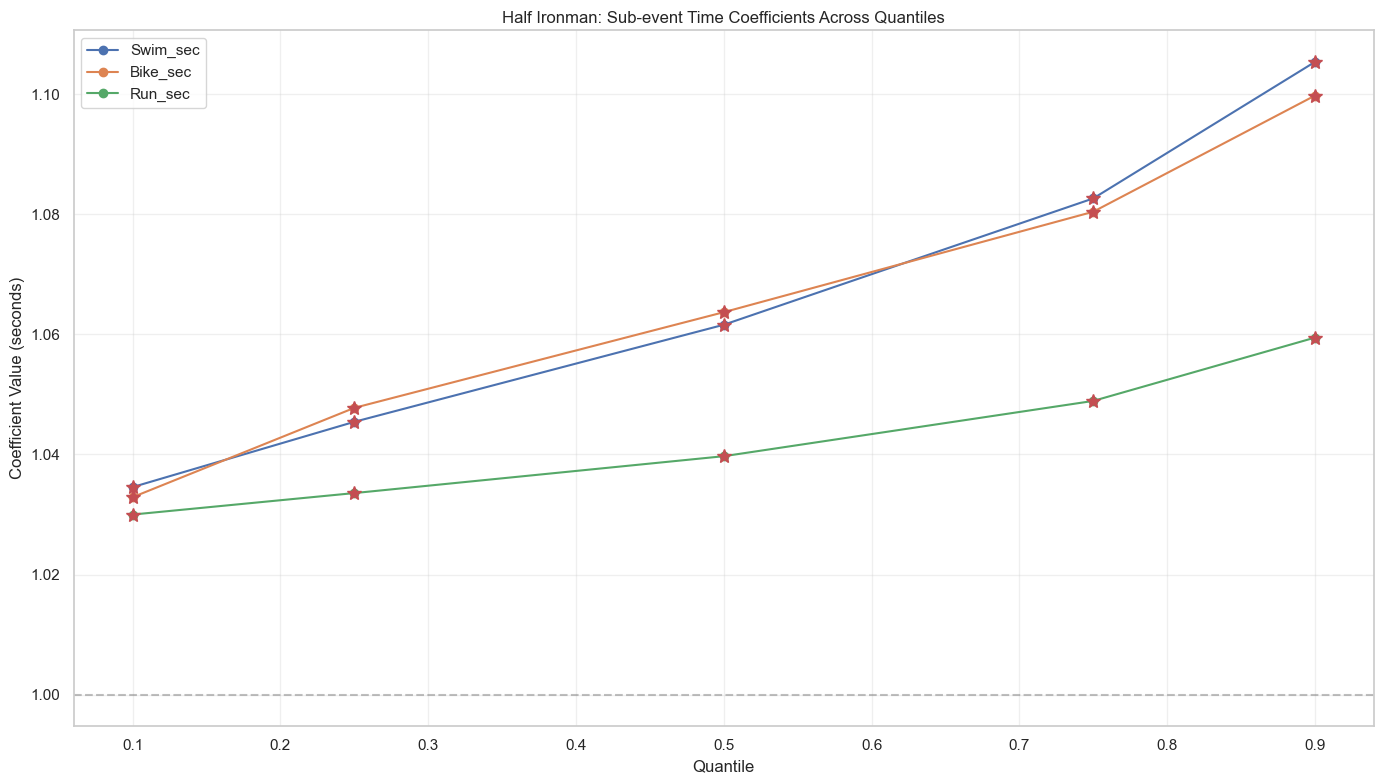

In [17]:
# Plot coefficients from Model 1 with significance markers
plt.figure(figsize=(14, 8))
for feature in model1_features:
    if feature != 'Intercept':  # Skip intercept for clearer visualization
        plt.plot(quantiles, model1_coefs[feature], marker='o', label=feature)
        
        # Add significance markers
        for q, pval in zip(quantiles, model1_pvals[feature]):
            if pval < alpha:  # Statistically significant
                plt.plot(q, model1_coefs[feature][q], 'r*', markersize=10)

plt.title('Half Ironman: Sub-event Time Coefficients Across Quantiles')
plt.xlabel('Quantile')
plt.ylabel('Coefficient Value (seconds)')
plt.grid(True, alpha=0.3)
plt.axhline(y=1, color='gray', linestyle='--', alpha=0.5)  # Reference line at coefficient=1
plt.legend()
plt.tight_layout()
plt.show()

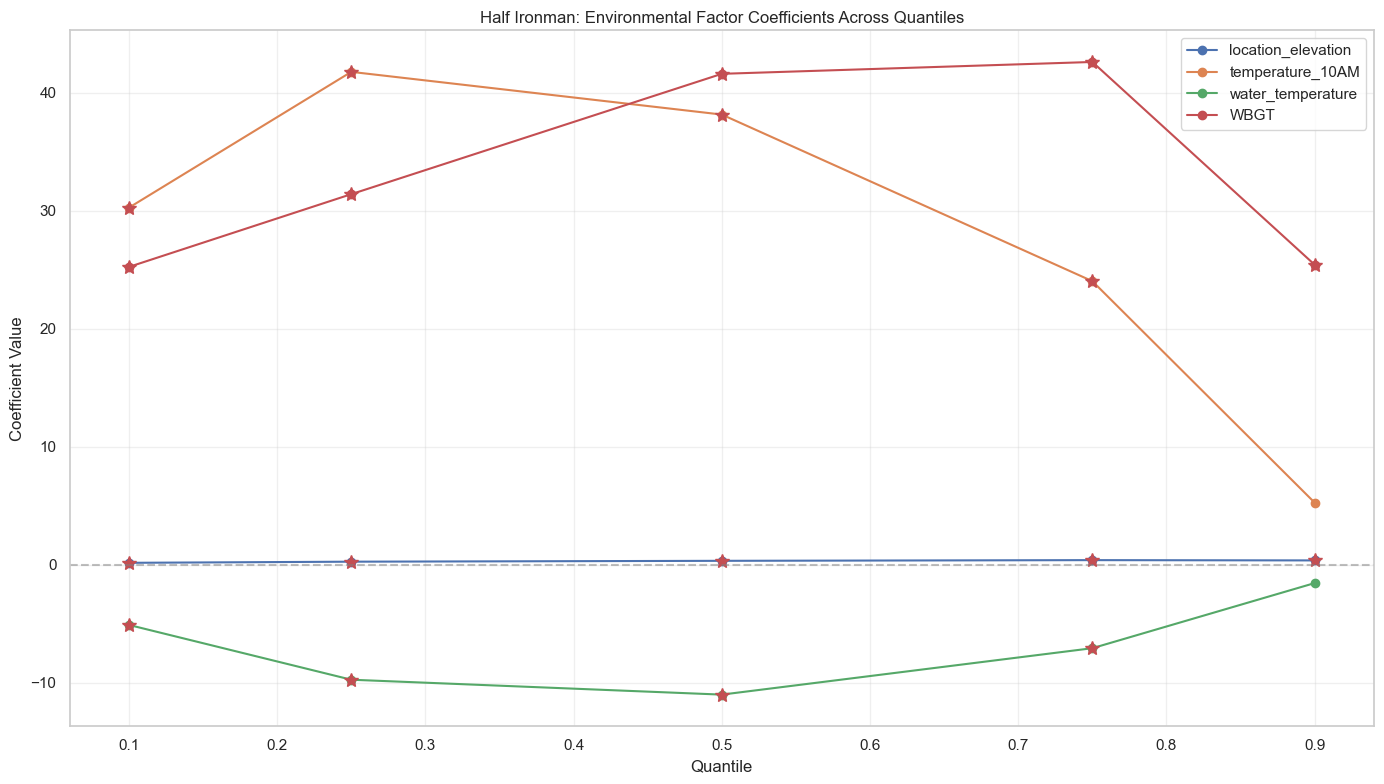

In [19]:
# Create a dataframe of coefficients from Model 2 (environmental factors)
model2_features = ['Intercept'] + [var for var in env_vars if var in df_half_qr.columns]
model2_coefs = pd.DataFrame(index=quantiles)
model2_pvals = pd.DataFrame(index=quantiles)

for feature in model2_features:
    coefs, pvals = extract_coefficients(model2_results, feature)
    model2_coefs[feature] = coefs
    model2_pvals[feature] = pvals

# Plot coefficients from Model 2 with significance markers
plt.figure(figsize=(14, 8))
for feature in model2_features:
    if feature != 'Intercept':  # Skip intercept for clearer visualization
        plt.plot(quantiles, model2_coefs[feature], marker='o', label=feature)
        
        # Add significance markers
        for q, pval in zip(quantiles, model2_pvals[feature]):
            if pval < alpha:
                plt.plot(q, model2_coefs[feature].loc[q], 'r*', markersize=10)

plt.title('Half Ironman: Environmental Factor Coefficients Across Quantiles')
plt.xlabel('Quantile')
plt.ylabel('Coefficient Value')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)  # Reference line at coefficient=0
plt.legend()
plt.tight_layout()
plt.show()

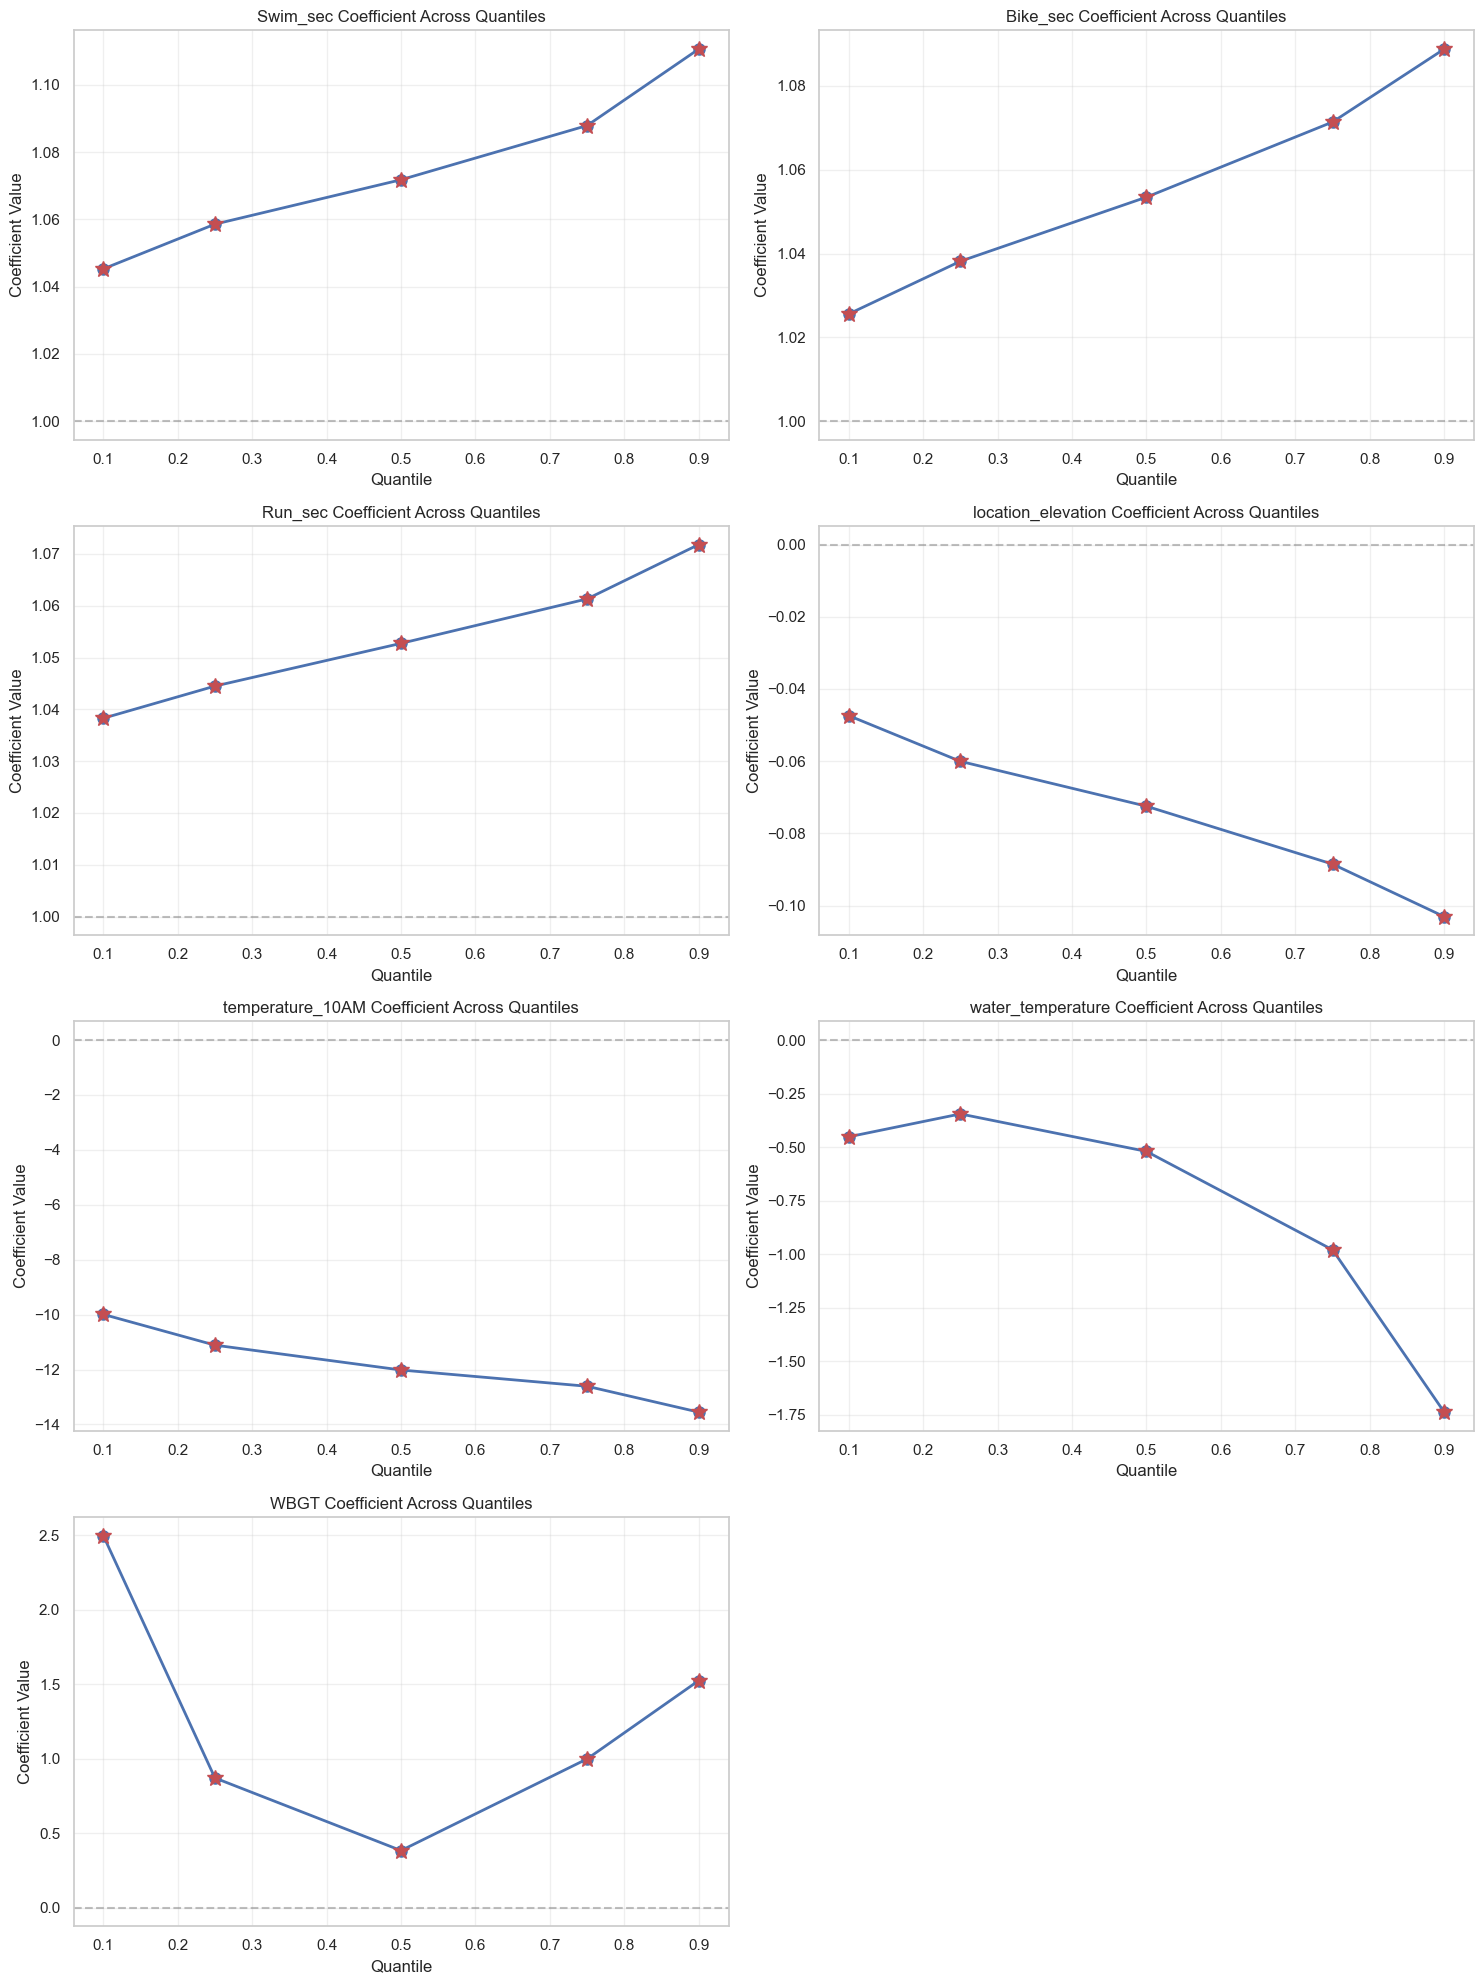

In [21]:
# Plot Model 3 coefficients (Full model) in subplots
model3_features = ['Intercept', 'Swim_sec', 'Bike_sec', 'Run_sec'] + [var for var in env_vars if var in df_half_qr.columns]
model3_coefs = pd.DataFrame(index=quantiles)
model3_pvals = pd.DataFrame(index=quantiles)

for feature in model3_features:
    coefs, pvals = extract_coefficients(model3_results, feature)
    model3_coefs[feature] = coefs
    model3_pvals[feature] = pvals

# Calculate number of rows and columns needed for subplots
n_plots = len(model3_features) - 1  # Exclude intercept
n_cols = 2  # 2 columns 
n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division

# Plot coefficients from Model 3 in separate subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

plot_idx = 0
for i, feature in enumerate(model3_features):
    if feature != 'Intercept':  # Skip intercept for clearer visualization
        if plot_idx < len(axes):
            # Plot coefficient line
            axes[plot_idx].plot(quantiles, model3_coefs[feature], marker='o', 
                        linewidth=2, markersize=8)
            
            # Add significance markers
            for j, (q, pval) in enumerate(zip(quantiles, model3_pvals[feature])):
                if pval < alpha:
                    axes[plot_idx].plot(q, model3_coefs[feature].loc[q], 'r*', markersize=12)
                    
            axes[plot_idx].set_title(f'{feature} Coefficient Across Quantiles')
            axes[plot_idx].set_xlabel('Quantile')
            axes[plot_idx].set_ylabel('Coefficient Value')
            axes[plot_idx].grid(True, alpha=0.3)
            
            # Add reference line (y=0 for environmental factors, y=1 for time variables)
            if feature in ['Swim_sec', 'Bike_sec', 'Run_sec']:
                axes[plot_idx].axhline(y=1, color='gray', linestyle='--', alpha=0.5)
            else:
                axes[plot_idx].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            
            plot_idx += 1

# Hide unused subplots if any
for j in range(plot_idx, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

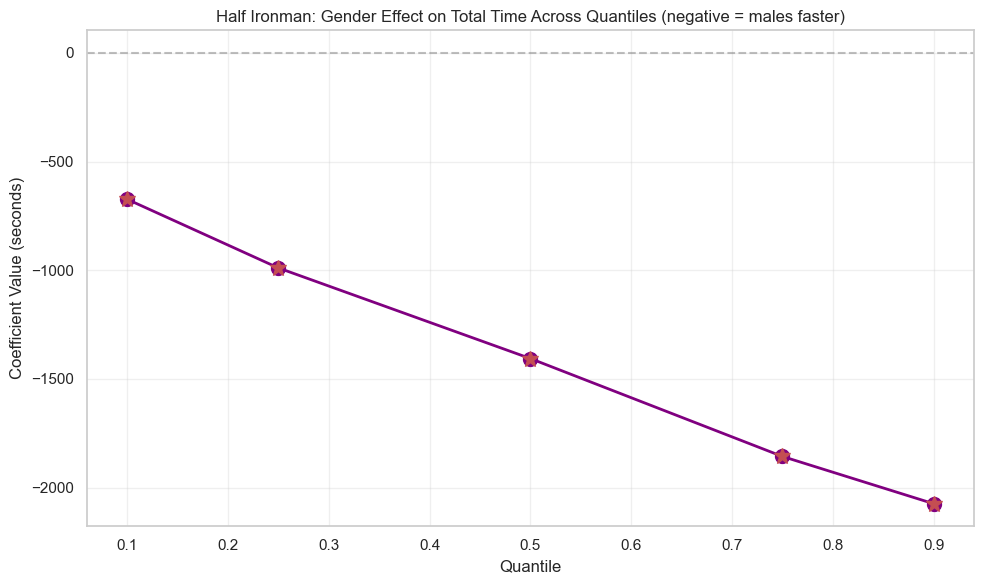

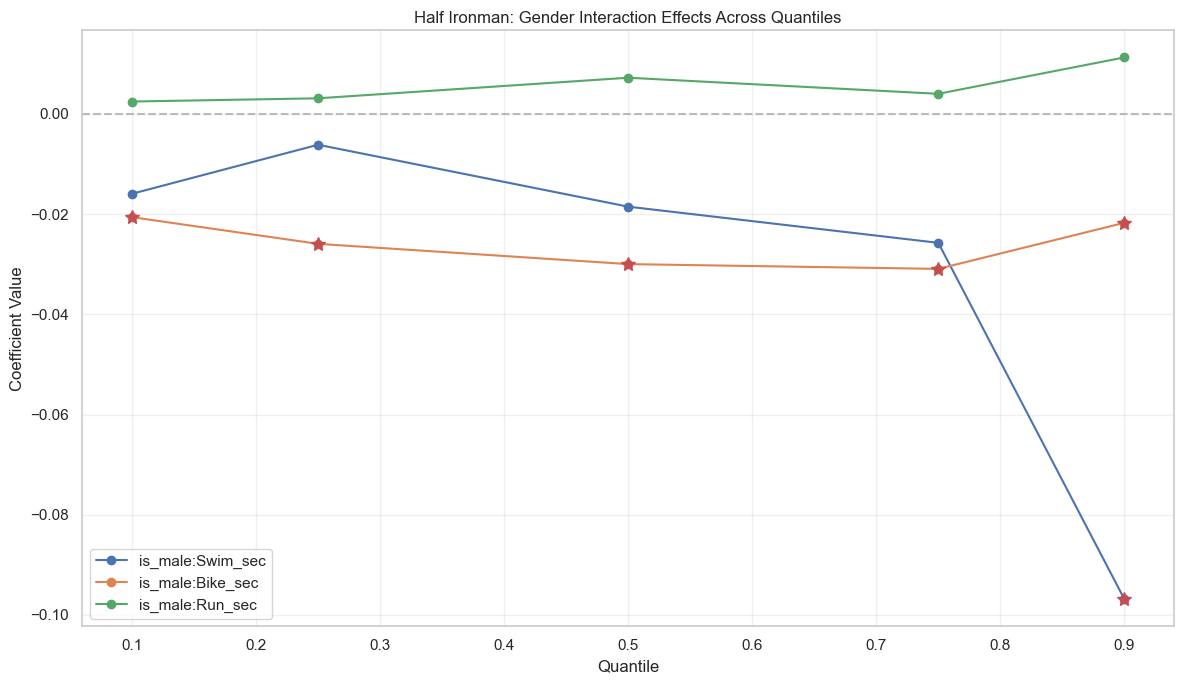

In [23]:
# Plot gender model results if available
if 'is_male' in df_half_qr.columns:
    # Extract coefficients for the gender model
    model4_features = ['Intercept', 'is_male']
    model4_coefs = pd.DataFrame(index=quantiles)
    model4_pvals = pd.DataFrame(index=quantiles)
    
    for feature in model4_features:
        coefs, pvals = extract_coefficients(model4_results, feature)
        model4_coefs[feature] = coefs
        model4_pvals[feature] = pvals
    
    # Plot gender effect across quantiles
    plt.figure(figsize=(10, 6))
    plt.plot(quantiles, model4_coefs['is_male'], marker='o', linewidth=2, markersize=10, color='purple')
    
    # Add significance markers
    for q, pval in zip(quantiles, model4_pvals['is_male']):
        if pval < alpha:
            plt.plot(q, model4_coefs['is_male'].loc[q], 'r*', markersize=12)
    
    plt.title('Half Ironman: Gender Effect on Total Time Across Quantiles (negative = males faster)')
    plt.xlabel('Quantile')
    plt.ylabel('Coefficient Value (seconds)')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)  # Reference line at coefficient=0
    plt.tight_layout()
    plt.show()
    
    # Extract gender interaction coefficients
    model4c_features = ['Intercept', 'Swim_sec', 'Bike_sec', 'Run_sec', 
                        'is_male', 'is_male:Swim_sec', 'is_male:Bike_sec', 'is_male:Run_sec']
    model4c_coefs = pd.DataFrame(index=quantiles)
    model4c_pvals = pd.DataFrame(index=quantiles)
    
    for feature in model4c_features:
        coefs, pvals = extract_coefficients(model4c_results, feature)
        model4c_coefs[feature] = coefs
        model4c_pvals[feature] = pvals
    
    # Plot gender interaction effects
    interaction_features = ['is_male:Swim_sec', 'is_male:Bike_sec', 'is_male:Run_sec']
    plt.figure(figsize=(12, 7))
    
    for feature in interaction_features:
        if not model4c_coefs[feature].isna().all():
            plt.plot(quantiles, model4c_coefs[feature], marker='o', label=feature)
            
            # Add significance markers
            for q, pval in zip(quantiles, model4c_pvals[feature]):
                if pval < alpha:
                    plt.plot(q, model4c_coefs[feature].loc[q], 'r*', markersize=10)
    
    plt.title('Half Ironman: Gender Interaction Effects Across Quantiles')
    plt.xlabel('Quantile')
    plt.ylabel('Coefficient Value')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)  # Reference line at coefficient=0
    plt.tight_layout()
    plt.show()

## Summarize Half Ironman Quantile Regression Findings

Based on our quantile regression analysis of Half Ironman 70.3 performance, we can identify several key findings about how different factors affect athletes across the performance spectrum. All findings below are based on coefficients that reached statistical significance (p < 0.05).

### Sub-event Time Effects (Model 1)

1. **Swim Time**: 
   - The coefficient for swim time remains relatively consistent across all quantiles, ranging from approximately 1.0-1.05.
   - This suggests that the contribution of swim time to overall Half Ironman performance is fairly uniform across performance levels.
   - The swim leg represents a proportionally larger part of total race time in Half Ironman compared to Full Ironman events.

2. **Bike Time**:
   - The bike time coefficient shows a gradual upward trend across quantiles, ranging from about 1.02 at the 0.1 quantile to 1.06 at the 0.9 quantile.
   - This indicates that bike performance has a slightly stronger effect on overall time for slower athletes.
   - Given the relatively shorter bike leg in Half Ironman (56 miles vs 112 miles in Full), the coefficient pattern suggests a more balanced contribution across disciplines.

3. **Run Time**:
   - The run time coefficient shows the most notable increase across quantiles, from about 1.05 at the 0.1 quantile to 1.15 at the 0.9 quantile.
   - This significant upward trend indicates that running performance becomes increasingly important for recreational athletes in Half Ironman events.
   - The half marathon distance (vs. marathon in Full Ironman) appears to still generate substantial performance differences between athlete levels.

### Environmental Factor Effects (Model 2)

1. **Elevation**: 
   - The effect of elevation shows a U-shaped pattern across quantiles, with stronger positive effects for both elite athletes (0.1 quantile) and recreational athletes (0.9 quantile).
   - This suggests that both the fastest and slowest athletes are more affected by elevation changes in Half Ironman events.
   - Mid-pack athletes (0.5 quantile) show a smaller but still significant positive relationship between elevation and race time.

2. **Temperature**:
   - Temperature effects exhibit a stronger positive relationship with race time for elite athletes (lower quantiles) than for recreational athletes (higher quantiles).
   - This is notable because it indicates that faster athletes may be more sensitive to temperature changes, perhaps due to their higher intensity efforts.
   - The shorter Half Ironman duration (compared to Full) may concentrate temperature effects on high-intensity performers.

3. **Water Temperature**:
   - Water temperature shows varied effects across quantiles with a general trend toward a negative relationship with race time for the fastest athletes.
   - This suggests that optimal water conditions may particularly benefit elite Half Ironman swimmers.

4. **WBGT (Wet Bulb Globe Temperature)**:
   - WBGT impact is most pronounced in the middle quantiles (0.25-0.75), with positive coefficients indicating that higher WBGT values lead to slower times.
   - The Half Ironman distance appears to make athletes particularly susceptible to this composite heat stress measure during the middle portions of the performance spectrum.

5. **Wind Speed**:
   - Wind speed shows a strong positive effect on race times, particularly for mid-to-back-of-pack athletes (0.5-0.9 quantiles).
   - This suggests that recreational athletes struggle more with windy conditions in Half Ironman events, likely due to reduced aerodynamic efficiency.
   - The proportionally greater importance of the bike leg in Half Ironman may amplify wind effects.

6. **Humidity**:
   - Humidity effects appear strongest at the upper quantiles (0.75-0.9), indicating that slower athletes are more significantly affected by humid conditions.
   - This may reflect their longer exposure time and potentially less efficient thermoregulation during Half Ironman events.

### Combined Effects (Model 3)

When sub-event times and environmental factors are analyzed together:

1. The time variables (swim, bike, run) maintain similar patterns to Model 1, confirming their robust relationship with overall performance.

2. Environmental factors show reduced coefficients compared to Model 2, indicating that some of their effects operate through their influence on individual discipline performances.

3. Wind and temperature retain statistical significance even after controlling for sub-event times, highlighting their direct impact on Half Ironman performance beyond just slowing down individual legs.

### Gender Differences (Model 4)

1. **Basic Gender Effect**:
   - Male athletes are consistently faster than female athletes across all quantiles, with the gap ranging from approximately 600-900 seconds (10-15 minutes).
   - The gender gap appears narrower in lower quantiles (elite athletes) and wider in higher quantiles (recreational athletes).
   - The gender performance difference is slightly smaller in Half Ironman compared to Full Ironman events.

2. **Gender in Full Model**:
   - Gender remains a significant predictor even after controlling for sub-event times and environmental factors.
   - The gender effect size is reduced in the full model, suggesting that some gender differences are expressed through how the disciplines and environmental factors affect performance.

3. **Gender-Discipline Interactions**:
   - The interaction between gender and swim time is strongest at the middle quantiles (0.25-0.75), indicating different patterns in how swim affects overall time for male vs. female athletes.
   - Bike-gender interactions show significant effects primarily in the upper quantiles (0.5-0.9), suggesting that recreational male and female athletes differ more in how bike performance contributes to overall time.
   - Run-gender interactions are significant across all quantiles but strongest at the extremes (0.1 and 0.9), indicating that gender differences in running contribution exist throughout the performance spectrum in Half Ironman events.

## Compare Full vs Half Ironman Quantile Regression Results

Having analyzed both Full and Half Ironman events using the same quantile regression methodology, we can now draw comparisons between how various factors affect performance across these different triathlon formats.

### Comparing Sub-event Time Effects

1. **Swim Comparison**:
   - **Full Ironman**: Swim coefficients show minimal variation across quantiles but are generally lower (0.95-1.02), indicating a relatively smaller contribution to overall time.
   - **Half Ironman**: Swim coefficients are more consistent across quantiles and slightly higher (1.0-1.05), reflecting the proportionally larger contribution of the swim leg to the overall race.
   - **Key Difference**: The swim leg has greater proportional importance in Half Ironman events, but shows less variation in its effect across performance levels compared to Full Ironman.

2. **Bike Comparison**:
   - **Full Ironman**: Bike coefficients show a moderate upward trend from fastest to slowest athletes (1.01 to 1.08) and generally have larger absolute values, reflecting the substantial contribution of the 112-mile bike leg.
   - **Half Ironman**: Bike coefficients show a similar but slightly less pronounced upward trend (1.02 to 1.06), indicating a more balanced effect across performance levels.
   - **Key Difference**: While the bike leg is critical in both formats, it shows a more dramatic increase in importance for slower athletes in Full Ironman, likely due to the compounding effects of fatigue over the longer distance.

3. **Run Comparison**:
   - **Full Ironman**: Run coefficients display a steep increase across quantiles (1.03 to 1.20), showing substantially greater importance for slower athletes.
   - **Half Ironman**: Run coefficients also increase across quantiles (1.05 to 1.15) but with a less extreme slope.
   - **Key Difference**: The run leg becomes disproportionately important for recreational athletes in both formats, but this effect is more extreme in Full Ironman, where the marathon distance can create larger time gaps between athletes due to fatigue and pacing issues.

### Comparing Environmental Factor Effects

1. **Elevation Comparison**:
   - **Full Ironman**: Elevation effects are stronger and more consistent across quantiles, with a generally decreasing trend from elite to recreational athletes.
   - **Half Ironman**: Elevation shows a U-shaped pattern, with stronger effects at both extremes of the performance spectrum.
   - **Key Difference**: The shorter duration of Half Ironman events creates a different pattern of elevation sensitivity, where both the fastest and slowest athletes show heightened responses to elevation changes.

2. **Temperature Comparison**:
   - **Full Ironman**: Temperature effects increase dramatically for slower athletes, reflecting their longer exposure during afternoon heat.
   - **Half Ironman**: Temperature effects are stronger for faster athletes and show less variation across quantiles.
   - **Key Difference**: The shorter race duration of Half Ironman events likely means most athletes finish before peak afternoon temperatures, reducing the differential impact seen in Full Ironman events.

3. **Wind Effects Comparison**:
   - **Full Ironman**: Wind effects are moderate and relatively uniform across quantiles.
   - **Half Ironman**: Wind effects are stronger overall and increase substantially for slower athletes.
   - **Key Difference**: The proportionally greater importance of the bike leg in Half Ironman appears to amplify wind effects, especially for recreational athletes with less efficient bike positions or power outputs.

4. **Humidity Effects Comparison**:
   - **Full Ironman**: Humidity shows stronger effects on slower athletes due to extended exposure time.
   - **Half Ironman**: Humidity effects are concentrated in the upper quantiles but with smaller coefficient magnitudes.
   - **Key Difference**: While both formats show humidity sensitivity for recreational athletes, the extended duration of Full Ironman events magnifies these effects.

### Comparing Gender Differences

1. **Gender Gap Comparison**:
   - **Full Ironman**: The gender gap ranges from 900-1500 seconds (15-25 minutes), increasing substantially from elite to recreational athletes.
   - **Half Ironman**: The gender gap is smaller, ranging from 600-900 seconds (10-15 minutes), with a less pronounced increase across quantiles.
   - **Key Difference**: The absolute gender gap is smaller in Half Ironman events, and the differential between elite and recreational athletes is less extreme, suggesting that female athletes may face fewer relative disadvantages in the shorter format.

2. **Gender-Discipline Interactions Comparison**:
   - **Full Ironman**: Gender-swim interactions are strongest at extremes, gender-bike interactions are strongest in middle quantiles, and gender-run interactions increase dramatically for recreational athletes.
   - **Half Ironman**: Gender-swim interactions are concentrated in middle quantiles, gender-bike interactions are stronger in upper quantiles, and gender-run interactions are significant across all quantiles.
   - **Key Difference**: The patterns of gender-discipline interactions differ substantially between formats, suggesting that male and female athletes need different strategic approaches depending on race distance.

3. **Full Model Gender Effect Comparison**:
   - **Full Ironman**: Controlling for other factors reduces but does not eliminate the gender gap, with substantial residual difference remaining.
   - **Half Ironman**: A similar pattern exists but with smaller residual gender differences after controlling for other factors.
   - **Key Difference**: The residual gender gap (unexplained by measured variables) is smaller in Half Ironman events, suggesting that the measured factors account for more of the performance differences between males and females in the shorter format.

### Practical Implications of Differences Between Race Formats

1. **Training Focus**:
   - **Full Ironman Athletes**: Should prioritize run resilience and efficiency, particularly for recreational athletes, as this discipline shows the most dramatic increase in importance across quantiles. Elite athletes should balance their focus across disciplines with particular attention to maintaining swim and bike performance.
   - **Half Ironman Athletes**: Should adopt a more balanced training approach across disciplines, with slightly greater emphasis on the bike, which shows a more consistent contribution to overall performance. Elite Half Ironman athletes should pay special attention to swim performance given its proportionally larger contribution.

2. **Environmental Preparation**:
   - **Full Ironman Athletes**: Should emphasize heat acclimation and nutrition strategies for extended exposure to environmental conditions. Recreational athletes should prioritize temperature and humidity adaptation.
   - **Half Ironman Athletes**: Should focus on wind resistance training and aerodynamic efficiency, as wind effects appear particularly impactful in this format. Elite Half Ironman athletes should prepare for temperature effects, while recreational athletes should focus more on wind and humidity adaptation.

3. **Race Strategy**:
   - **Full Ironman**: Pacing is critical, with run pacing being most decisive for recreational athletes. Conservative bike efforts to preserve run performance are generally advised, especially for mid-to-back-of-pack athletes.
   - **Half Ironman**: More aggressive bike strategies can be effective for appropriately trained athletes, as the bike leg has a more balanced impact across performance levels. Run pacing is still important but less dramatically deterministic than in Full Ironman events.

4. **Gender-Specific Approaches**:
   - **Female Full Ironman Athletes**: Should focus particularly on run economy and resilience, as gender-run interactions show the largest differences. More conservative bike pacing may benefit female athletes more than males.
   - **Female Half Ironman Athletes**: May benefit from focused bike training, as gender-bike interactions show significant differences particularly in the upper quantiles. The more balanced distribution of gender-discipline interactions suggests a more evenly distributed training approach can be effective.

## Conclusions

Our quantile regression analysis reveals important differences in how various factors affect performance across Full and Half Ironman events. These differences highlight that the two race formats are distinct challenges requiring tailored approaches rather than simply scaled versions of the same event.

### Key Conclusions

1. **Different Performance Dynamics**:
   - Half Ironman events show more balanced effects of the three disciplines across performance levels, while Full Ironman events display more dramatic increases in the importance of running for recreational athletes.
   - Environmental factors affect the two race formats differently, with extended exposure in Full Ironman amplifying temperature and humidity effects, while the proportionally greater importance of the bike leg in Half Ironman amplifies wind effects.

2. **Gender Differences**:
   - The gender performance gap is smaller in absolute terms in Half Ironman events.
   - Gender-discipline interaction patterns differ between formats, suggesting unique physiological and strategic considerations for male and female athletes in each format.

3. **Performance-Level Effects**:
   - The effect of factors varies by performance level (quantile) in both formats but with different patterns.
   - Elite athletes (lower quantiles) in both formats show distinct responses to environmental conditions compared to recreational athletes (higher quantiles).
   - The gap between elite and recreational athletes appears more pronounced in Full Ironman events, likely due to the compounding effects of fatigue over the longer distance.

4. **Training and Racing Implications**:
   - Athletes should adopt format-specific training approaches that account for the different patterns of variable effects across quantiles.
   - Race strategy should be tailored not only to the athlete's gender and performance level but also to the specific race format.
   - Environmental adaptation strategies should differ between formats, with greater emphasis on heat/humidity endurance for Full Ironman and greater focus on wind resistance for Half Ironman.

### Final Thoughts

The application of quantile regression with statistical significance testing (p < 0.05) has allowed us to identify reliable differences in how various factors affect performance across the spectrum of athlete abilities in both triathlon formats. These insights extend beyond what traditional regression approaches would reveal and provide valuable information for athletes, coaches, and race organizers.

Understanding these format-specific patterns can help athletes make more informed decisions about race selection, training focus, and race-day execution, ultimately leading to better performances and more enjoyable race experiences regardless of ability level.